Cell 1

In [151]:
print(1-1/2.08 )

0.5192307692307693


In [155]:
print((1/2.08**2)*0.23)

0.05316198224852071


In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, gamma
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import time

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
GRID_SIZE = 0.5  # km x km (500m x 500m)
POPULATION_DENSITY = 4680  # Updated density: people per km²
N_AGENTS = int(POPULATION_DENSITY * GRID_SIZE ** 2)  # Now 1170 agents

# Movement parameters
AVERAGE_DISTANCE_TRAVELLED = 0.92  # km per DAY (walking only, from research)
DT = 0.1 # Time step = 1/10 of a day 

# Calculate diffusion coefficient from average distance traveled PER DAY
D = (AVERAGE_DISTANCE_TRAVELLED ** 2) / (4 * 1.0)  # Still in km²/day

SIMULATION_DAYS = 500
SIMULATION_STEPS = int(SIMULATION_DAYS / DT)  # Total timesteps

# Disease parameters
INFECTIOUSNESS_THRESHOLD = 0.05  # Below this, person recovers
DECAY_MULTIPLIER = 1.0  # Controls how fast infectiousness decays after peak

# Transmission parameters
MAX_TRANSMISSION_DISTANCE = 0.005  # only 5m otherwise infection was spreading so much by long range that local social distancing didnt affect  results...
MINIMUM_PROXIMITY = 0.0  # Social distancing parameter (meters)

print(f"Simulation setup:")
print(f"Grid size: {GRID_SIZE} km x {GRID_SIZE} km")
print(f"Population: {N_AGENTS} agents")
print(f"Effective density: {N_AGENTS / (GRID_SIZE**2):.0f} per km²")
print(f"Average agent spacing: ~{np.sqrt((GRID_SIZE**2)/N_AGENTS)*1000:.1f} meters")
print(f"\nTime parameters:")
print(f"Timestep dt: {DT} days = {DT*24:.1f} hours")
print(f"Simulation duration: {SIMULATION_DAYS} days = {SIMULATION_STEPS} timesteps")
print(f"\nMovement parameters:")
print(f"Average distance travelled per day: {AVERAGE_DISTANCE_TRAVELLED} km")
print(f"Calculated diffusion coefficient D: {D:.4f} km²/day")
print(f"Expected RMS movement per timestep: {np.sqrt(4*D*DT):.4f} km = {np.sqrt(4*D*DT)*1000:.1f} m")
print(f"Expected RMS movement per day: {np.sqrt(4*D*1.0):.2f} km")
print(f"\nTransmission parameters:")
print(f"Max transmission distance: {MAX_TRANSMISSION_DISTANCE*1000:.0f} meters")
print(f"Minimum proximity (social distancing): {MINIMUM_PROXIMITY} meters")
print(f"Decay multiplier: {DECAY_MULTIPLIER}")
print(f"\nNote: Agents check for transmission {int(1/DT)} times per day")

Simulation setup:
Grid size: 0.5 km x 0.5 km
Population: 1170 agents
Effective density: 4680 per km²
Average agent spacing: ~14.6 meters

Time parameters:
Timestep dt: 0.1 days = 2.4 hours
Simulation duration: 500 days = 5000 timesteps

Movement parameters:
Average distance travelled per day: 0.92 km
Calculated diffusion coefficient D: 0.2116 km²/day
Expected RMS movement per timestep: 0.2909 km = 290.9 m
Expected RMS movement per day: 0.92 km

Transmission parameters:
Max transmission distance: 5 meters
Minimum proximity (social distancing): 0.0 meters
Decay multiplier: 1.0

Note: Agents check for transmission 10 times per day


Cell 2

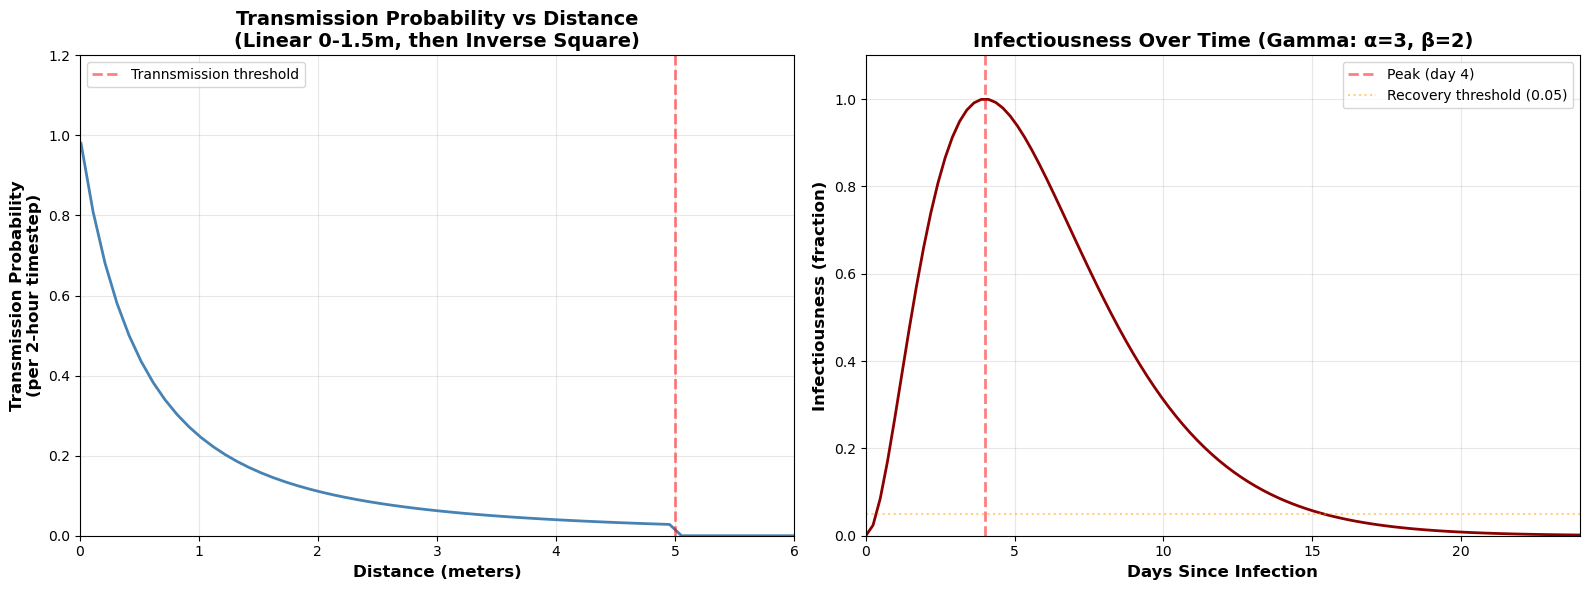


Profiles plotted and saved to: transmission_infectiousness_profiles.png


In [157]:
from scipy.stats import gamma

@dataclass
class Agent:
    """Represents a person in the simulation"""
    x: float
    y: float
    status: str
    time_infected: float = 0.0
    infected_by_generation: int = -1
    decay_multiplier: float = None
    grid_size: float = None
    
    def __post_init__(self):
        """Validate that required parameters are provided"""
        if self.decay_multiplier is None:
            self.decay_multiplier = DECAY_MULTIPLIER
        if self.grid_size is None:
            self.grid_size = GRID_SIZE
    
    def move(self, D, dt):
        """Update position based on Brownian motion"""
        sigma = np.sqrt(2 * D * dt)
        dx = np.random.normal(0, sigma)
        dy = np.random.normal(0, sigma)
        
        # Update position with periodic boundary conditions
        self.x = (self.x + dx) % self.grid_size
        self.y = (self.y + dy) % self.grid_size
    
    def get_infectiousness(self):
        """Calculate infectiousness using gamma distribution with decay multiplier"""
        if self.status != 'infected':
            return 0.0
        
        # Gamma distribution parameters
        alpha = 3.0
        beta = 2.0
        
        # Calculate the peak (mode) of the gamma distribution
        peak_day = (alpha - 1) * beta
        
        # Calculate gamma PDF at current time (continuous)
        gamma_value = gamma.pdf(self.time_infected, a=alpha, scale=beta)
        
        # Normalize so peak = 1.0
        peak_value_gamma = gamma.pdf(peak_day, a=alpha, scale=beta)
        normalized_value = gamma_value / peak_value_gamma
        
        if self.time_infected <= peak_day:
            # Before or at peak: use gamma as-is
            infectiousness = normalized_value
        else:
            # After peak: apply decay multiplier
            peak_infectiousness = 1.0
            drop_from_peak = peak_infectiousness - normalized_value
            adjusted_drop = drop_from_peak * self.decay_multiplier
            infectiousness = peak_infectiousness - adjusted_drop
        
        infectiousness = max(0.0, float(infectiousness))
        return infectiousness
    
    def update_infection_status(self, dt):
        """Update infection progression"""
        if self.status == 'infected':
            self.time_infected += dt
            
            # Gamma parameters
            alpha = 3.0
            beta = 2.0
            peak_day = (alpha - 1) * beta  # Day 4
            
            # Only check for recovery AFTER peak infectiousness
            if self.time_infected > peak_day:
                if self.get_infectiousness() < INFECTIOUSNESS_THRESHOLD:
                    self.status = 'recovered'
                    return True
        return False

def transmission_probability_distance(distance, minimum_proximity=0.0):
    """
    Transmission probability based on distance (at peak infectiousness)
    - 0 to 1.5m: LINEAR from 50% at 0m to 20% at 1.5m
    - > 1.5m: inverse square law starting from 20% at 1.5m
    
    Args:
        distance: Physical distance in km
        minimum_proximity: Minimum proximity in meters (social distancing)
    """
    # Convert distance from km to meters
    distance_m = distance * 1000
    
    # Apply minimum proximity (social distancing)
    effective_distance_m = max(distance_m, minimum_proximity)

    if effective_distance_m < 5:
        prob = 1/(effective_distance_m+1)**2
    else:
        prob = 0
    return prob

    ##Code below this now pointless, but keep in case want to revert

    
    # Parameters
    r0 = 1.5  # meters - transition point
    p_at_0 = 1
    p_at_r0 = 0.5
    
    if effective_distance_m <= r0:
        # Close range: linear interpolation from p_at_0 to p_at_r0
        # P(d) = p_at_0 + (p_at_r0 - p_at_0) * (d / r0)
        prob = p_at_0 + (p_at_r0 - p_at_0) * (effective_distance_m / r0)
        return prob
    else:
        # Far range: inverse square law
        # P(r) = k / r²
        # At r = r0: p_at_r0 = k / r0²
        # Therefore: k = p_at_r0 × r0²
        k = p_at_r0 * (r0 ** 2)
        prob = k / (effective_distance_m ** 2)
        return prob


# Create two-panel plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Transmission probability vs distance (100 points, 0-10m)
ax1 = axes[0]
distances_m = np.linspace(0.01, 10, 100)  # Start from 0.01 to avoid division issues
distances_km = distances_m / 1000
probabilities = [transmission_probability_distance(d, minimum_proximity=MINIMUM_PROXIMITY) for d in distances_km]

ax1.plot(distances_m, probabilities, linewidth=2, color='steelblue')
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Trannsmission threshold')
if MINIMUM_PROXIMITY > 0:
    ax1.axvline(x=MINIMUM_PROXIMITY, color='purple', linestyle='-.', alpha=0.7, linewidth=2, 
                label=f'Min proximity ({MINIMUM_PROXIMITY}m)')
ax1.set_xlabel('Distance (meters)', fontsize=12, fontweight='bold')
ax1.set_ylabel(f'Transmission Probability\n(per {DT*24:.0f}-hour timestep)', fontsize=12, fontweight='bold')
ax1.set_title(f'Transmission Probability vs Distance\n(Linear 0-1.5m, then Inverse Square)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 1.2)

# Plot 2: Infectiousness over time
ax2 = axes[1]
days = np.linspace(0, 24, 100)
test_agent = Agent(0, 0, 'infected', time_infected=0, infected_by_generation=0)
infectiousness_values = []
for day in days:
    test_agent.time_infected = day
    infectiousness_values.append(test_agent.get_infectiousness())

ax2.plot(days, infectiousness_values, linewidth=2, color='darkred')
ax2.axvline(x=4, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Peak (day 4)')
ax2.axhline(y=INFECTIOUSNESS_THRESHOLD, color='orange', linestyle=':', alpha=0.5, linewidth=1.5, 
            label=f'Recovery threshold ({INFECTIOUSNESS_THRESHOLD})')
ax2.set_xlabel('Days Since Infection', fontsize=12, fontweight='bold')
ax2.set_ylabel('Infectiousness (fraction)', fontsize=12, fontweight='bold')
ax2.set_title(f'Infectiousness Over Time (Gamma: α=3, β=2)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0, 24)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('transmission_infectiousness_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nProfiles plotted and saved to: transmission_infectiousness_profiles.png")

Cell 3

In [111]:
def initialize_population(n_agents, initial_infected, initial_recovered=0, grid_size=GRID_SIZE, 
                         decay_multiplier=DECAY_MULTIPLIER, for_r0_calculation=False):
    """Initialize agents with random positions
    
    Args:
        n_agents: Total number of agents
        initial_infected: Number starting infected
        initial_recovered: Number starting recovered (immune)
        grid_size: Size of simulation grid
        decay_multiplier: Infectiousness decay parameter
        for_r0_calculation: Whether this is for R0 calculation
    """
    agents = []
    
    for i in range(n_agents):
        x = np.random.uniform(0, grid_size)
        y = np.random.uniform(0, grid_size)
        
        if i < initial_infected:
            initial_time = np.random.uniform(0.0, 1.0)
            agent = Agent(x, y, 'infected', time_infected=initial_time,
                         infected_by_generation=0, decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        elif i < initial_infected + initial_recovered:
            agent = Agent(x, y, 'recovered', decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        else:
            agent = Agent(x, y, 'susceptible', decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        
        agents.append(agent)
    
    return agents

Cell 4

In [159]:
def calculate_distance(agent1, agent2):
    """Calculate distance between two agents considering periodic boundaries"""
    grid_size = agent1.grid_size
    dx = abs(agent1.x - agent2.x)
    dy = abs(agent1.y - agent2.y)
    
    dx = min(dx, grid_size - dx)
    dy = min(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def calculate_distance_coords(x1, y1, x2, y2, grid_size):
    """Calculate distance between coordinates considering periodic boundaries"""
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    
    dx = min(dx, grid_size - dx)
    dy = min(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def calculate_distances_vectorized(infected_x, infected_y, susceptible_positions, grid_size):
    """Vectorized distance calculation"""
    dx = np.abs(susceptible_positions[:, 0] - infected_x)
    dy = np.abs(susceptible_positions[:, 1] - infected_y)
    
    dx = np.minimum(dx, grid_size - dx)
    dy = np.minimum(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def attempt_transmission(infected_agent, susceptible_agent, max_distance, minimum_proximity=0.0):
    """Attempt transmission with minimum proximity parameter"""
    distance = calculate_distance(infected_agent, susceptible_agent)
    
    if distance > max_distance:
        return False
    
    p_distance = transmission_probability_distance(distance, minimum_proximity=minimum_proximity)
    p_infectiousness = infected_agent.get_infectiousness()
    
    p_transmission = p_distance * p_infectiousness
    
    if np.random.random() < p_transmission:
        return True
    
    return False

def transmission_step_optimized(agents, max_transmission_distance=MAX_TRANSMISSION_DISTANCE,
                               minimum_proximity=0.0, for_r0_calculation=False):
    """Optimized transmission with minimum proximity parameter"""
    if for_r0_calculation:
        infected_agents = [a for a in agents if a.status == 'infected' and a.infected_by_generation == 0]
    else:
        infected_agents = [a for a in agents if a.status == 'infected']
    
    susceptible_agents = [a for a in agents if a.status == 'susceptible']
    
    if len(infected_agents) == 0 or len(susceptible_agents) == 0:
        return 0
    
    grid_size = agents[0].grid_size
    susceptible_positions = np.array([[a.x, a.y] for a in susceptible_agents])
    newly_infected_indices = set()
    
    for infected in infected_agents:
        distances = calculate_distances_vectorized(infected.x, infected.y, 
                                                   susceptible_positions, grid_size)
        
        nearby_mask = distances <= max_transmission_distance
        nearby_indices = np.where(nearby_mask)[0]
        
        if len(nearby_indices) == 0:
            continue
        
        infectiousness = infected.get_infectiousness()
        nearby_distances = distances[nearby_indices]
        
        transmission_probs = np.zeros(len(nearby_distances))
        for i, d in enumerate(nearby_distances):
            transmission_probs[i] = transmission_probability_distance(d, minimum_proximity=minimum_proximity) * infectiousness
        
        random_rolls = np.random.random(len(nearby_indices))
        successful_transmissions = nearby_indices[random_rolls < transmission_probs]
        
        for idx in successful_transmissions:
            if idx not in newly_infected_indices:
                newly_infected_indices.add(idx)
    
    new_infections = []
    for idx in newly_infected_indices:
        susceptible = susceptible_agents[idx]
        generation = infected_agents[0].infected_by_generation + 1
        new_infections.append((susceptible, generation))
    
    for agent, generation in new_infections:
        agent.status = 'infected'
        agent.time_infected = 0.0  # FIXED: was days_infected
        agent.infected_by_generation = generation
    
    return len(new_infections)


Cell 5

In [149]:
def simulate_r0(n_agents=N_AGENTS, grid_size=GRID_SIZE, decay_multiplier=DECAY_MULTIPLIER,
                max_transmission_distance=MAX_TRANSMISSION_DISTANCE, minimum_proximity=0.0,
                n_days=50, verbose=False):
    """R0 calculation with quarter-day timesteps - always uses 1 initial infected"""
    # R0 is by definition calculated with exactly 1 initial infected
    agents = initialize_population(n_agents, initial_infected=1, grid_size=grid_size,
                                  decay_multiplier=decay_multiplier, for_r0_calculation=True)
    
    total_infections = 0
    n_steps = int(n_days / DT)
    
    for step in range(n_steps):
        for agent in agents:
            agent.move(D, DT)
        
        new_infections = transmission_step_optimized(agents, 
                                                     max_transmission_distance=max_transmission_distance,
                                                     minimum_proximity=minimum_proximity,
                                                     for_r0_calculation=True)
        total_infections += new_infections
        
        for agent in agents:
            agent.update_infection_status(DT)
        
        gen0_active = any(a.infected_by_generation == 0 and a.status == 'infected' for a in agents)
        if not gen0_active and step > 0:
            if verbose:
                current_day = step * DT
                print(f"Generation-0 recovered on day {current_day:.1f} (step {step})")
            break
    
    r0 = total_infections / 1  # Always divide by 1 for R0
    
    if verbose:
        density = n_agents / (grid_size ** 2)
        print(f"R0 = {r0:.2f} (density={density:.0f}/km², grid={grid_size:.2f}km, decay={decay_multiplier:.2f}, min_prox={minimum_proximity}m)")
    
    return r0

# Multiple runs

#D=(AVERAGE_DISTANCE_TRAVELLED ** 2) / (4 * 1.0)  ##D still >> 1 with this so virus would still spread - limitation...
n_runs = 50
print("\n" + "="*60)
print(f"MULTIPLE R0 CALCULATIONS ({n_runs} runs)")
print("="*60)
start = time.time()

AVERAGE_DISTANCE_TRAVELLED=0.92
r0_values = [simulate_r0(verbose=False) for _ in range(n_runs)]
end = time.time()

print(f"DT value: {DT}")
print(f"R0 values: {[f'{r:.2f}' for r in r0_values]}")
print(f"Mean R0: {np.mean(r0_values):.2f}")
print(f"Std R0: {stats.sem(r0_values):.2f}")
print(f"Range: [{np.min(r0_values):.2f}, {np.max(r0_values):.2f}]")
print(f"Total computation time: {end-start:.2f} seconds ({(end-start)/n_runs:.2f} sec per run)")


MULTIPLE R0 CALCULATIONS (50 runs)
DT value: 0.1
R0 values: ['3.00', '1.00', '1.00', '5.00', '0.00', '7.00', '0.00', '3.00', '5.00', '3.00', '1.00', '1.00', '2.00', '1.00', '2.00', '4.00', '2.00', '1.00', '3.00', '2.00', '1.00', '2.00', '6.00', '4.00', '2.00', '0.00', '1.00', '1.00', '1.00', '2.00', '0.00', '4.00', '1.00', '3.00', '2.00', '0.00', '1.00', '3.00', '3.00', '2.00', '3.00', '2.00', '5.00', '0.00', '2.00', '2.00', '1.00', '0.00', '3.00', '0.00']
Mean R0: 2.08
Std R0: 0.23
Range: [0.00, 7.00]
Total computation time: 25.86 seconds (0.52 sec per run)


cell 5a1

In [1025]:
from scipy.optimize import curve_fit

AVERAGE_DISTANCE_TRAVELLED=0.92 

print("="*80)
print("R0 VS POPULATION DENSITY SWEEP - DATA COLLECTION")
print("="*80)

# Keep N_AGENTS constant, vary grid_size to change density
n_agents_fixed = N_AGENTS
n_runs_per_density = 50
n_days = 50

# Define densities linearly, then calculate corresponding grid sizes
densities = np.linspace(750, 8500, 20)  # 10 linearly spaced densities
grid_sizes = [np.sqrt(n_agents_fixed / density) for density in densities]

print(f"Fixed number of agents: {n_agents_fixed}")
print(f"Testing {len(densities)} different densities")
print(f"Density range: {min(densities):.0f} to {max(densities):.0f} people/km²")
print(f"Runs per density: {n_runs_per_density}")
print(f"Total simulations: {len(densities) * n_runs_per_density}")
print(f"Max transmission distance: {MAX_TRANSMISSION_DISTANCE}"

results_density = []

start_total = time.time()
for i, (density, grid_size) in enumerate(zip(densities, grid_sizes)):
    print(f"\n[{i+1}/{len(densities)}] Testing density = {density:.0f} people/km² (grid = {grid_size:.3f} km)...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_density):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size, 
                        decay_multiplier=DECAY_MULTIPLIER, n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    std_r0 = np.std(r0_values)
    
    results_density.append({
        'density': density,
        'mean_r0': mean_r0,
        'sem_r0': stats.sem(r0_values)
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {sem_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_density = pd.DataFrame(results_density)
df_density.to_csv('r0_vs_density.csv', index=False)

print("\n" + "="*80)
print("DENSITY SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_density.csv")

R0 VS POPULATION DENSITY SWEEP - DATA COLLECTION
Fixed number of agents: 1170
Testing 20 different densities
Density range: 750 to 8500 people/km²
Runs per density: 50
Total simulations: 1000

[1/20] Testing density = 750 people/km² (grid = 1.249 km)...
  Mean R0 = 0.22 ± 0.46 (time: 31.8s)

[2/20] Testing density = 1158 people/km² (grid = 1.005 km)...
  Mean R0 = 0.38 ± 0.52 (time: 30.6s)

[3/20] Testing density = 1566 people/km² (grid = 0.864 km)...
  Mean R0 = 0.56 ± 0.75 (time: 32.3s)

[4/20] Testing density = 1974 people/km² (grid = 0.770 km)...
  Mean R0 = 1.00 ± 0.85 (time: 31.2s)

[5/20] Testing density = 2382 people/km² (grid = 0.701 km)...
  Mean R0 = 1.08 ± 0.89 (time: 33.3s)

[6/20] Testing density = 2789 people/km² (grid = 0.648 km)...
  Mean R0 = 1.32 ± 1.12 (time: 31.9s)

[7/20] Testing density = 3197 people/km² (grid = 0.605 km)...
  Mean R0 = 1.72 ± 1.27 (time: 30.7s)

[8/20] Testing density = 3605 people/km² (grid = 0.570 km)...
  Mean R0 = 1.60 ± 1.25 (time: 31.3s)



cell 5a2

R0 VS POPULATION DENSITY - PLOTTING
Linear fit:
  R0 = 0.000443 × density + 0.05
  Slope = 0.000443
  Intercept = 0.05


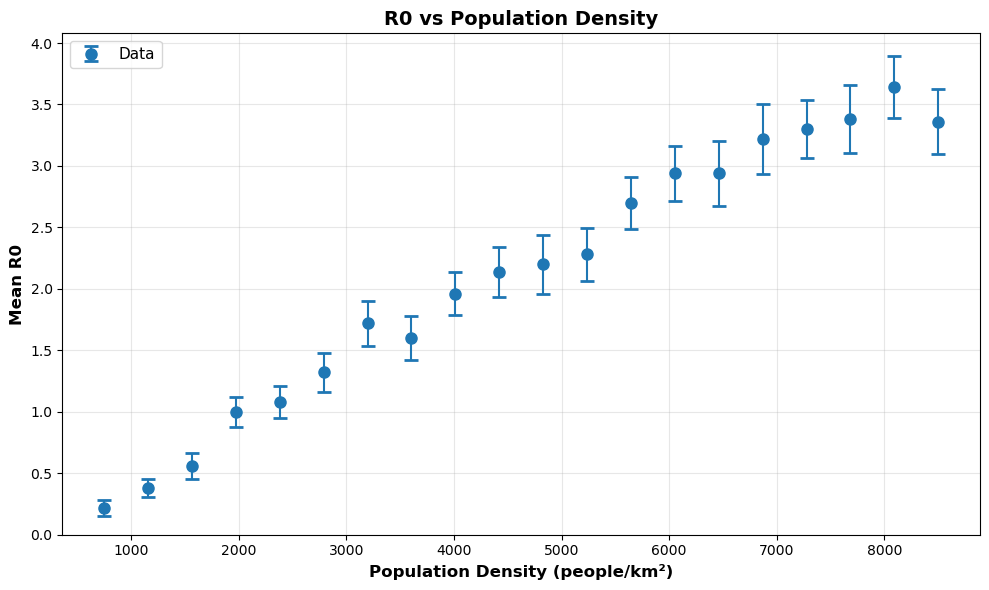


Plot saved to: r0_vs_density.png


In [1030]:
print("="*80)
print("R0 VS POPULATION DENSITY - PLOTTING")
print("="*80)

# Linear function for curve_fit
def linear(x, m, c):
    return m * x + c

# Fit linear model
params, _ = curve_fit(linear, df_density['density'], df_density['mean_r0'])

print("Linear fit:")
print(f"  R0 = {params[0]:.6f} × density + {params[1]:.2f}")
print(f"  Slope = {params[0]:.6f}")
print(f"  Intercept = {params[1]:.2f}")

# Plot with error bars and line of best fit
plt.figure(figsize=(10, 6))
plt.errorbar(df_density['density'], df_density['mean_r0'], 
             yerr=df_density['sem_r0'], fmt='o', markersize=8, capsize=5, capthick=2, 
             label='Data')

plt.xlabel('Population Density (people/km²)', fontsize=12, fontweight='bold')
plt.ylabel('Mean R0', fontsize=12, fontweight='bold')
plt.title('R0 vs Population Density', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('r0_vs_density.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_density.png")

cell 5b1

In [1032]:
from scipy.optimize import curve_fit

print("="*80)
print("R0 VS DECAY MULTIPLIER (RECOVERY TIME) SWEEP - DATA COLLECTION")
print("="*80)

n_agents_fixed = N_AGENTS
grid_size_fixed = GRID_SIZE
n_runs_per_multiplier = 20
n_days = 50

# Decay multipliers: 5 points below 1, 1 point at 1, 5 points above 1
decay_multipliers = np.concatenate([
    np.linspace(0.2, 0.9, 5),
    [1.0],
    np.linspace(1.1, 2.5, 5)
])

print(f"Fixed: {n_agents_fixed} agents, {grid_size_fixed} km grid")
print(f"Testing {len(decay_multipliers)} different decay multipliers")
print(f"Decay multipliers: {[f'{d:.2f}' for d in decay_multipliers]}")
print(f"Runs per multiplier: {n_runs_per_multiplier}")
print(f"Total simulations: {len(decay_multipliers) * n_runs_per_multiplier}")
print(f"Max transmission distance: {MAX_TRANSMISSION_DISTANCE}"

results_decay = []

start_total = time.time()
for i, decay_mult in enumerate(decay_multipliers):
    print(f"\n[{i+1}/{len(decay_multipliers)}] Testing decay_multiplier = {decay_mult:.2f}...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_multiplier):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size_fixed,
                        decay_multiplier=decay_mult, n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    sem_r0 = stats.sem(r0_values)
    
    results_decay.append({
        'decay_multiplier': decay_mult,
        'mean_r0': mean_r0,
        'sem_r0': stats.sem(r0_values)
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {sem_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_decay = pd.DataFrame(results_decay)
df_decay.to_csv('r0_vs_decay_multiplier.csv', index=False)

print("\n" + "="*80)
print("DECAY MULTIPLIER SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_decay_multiplier.csv")
print("\nSummary:")
print(df_decay.to_string(index=False))

R0 VS DECAY MULTIPLIER (RECOVERY TIME) SWEEP - DATA COLLECTION
Fixed: 1170 agents, 0.5 km grid
Testing 11 different decay multipliers
Decay multipliers: ['0.20', '0.38', '0.55', '0.72', '0.90', '1.00', '1.10', '1.45', '1.80', '2.15', '2.50']
Runs per multiplier: 20
Total simulations: 220

[1/11] Testing decay_multiplier = 0.20...
  Mean R0 = 12.55 ± 0.92 (time: 44.7s)

[2/11] Testing decay_multiplier = 0.38...
  Mean R0 = 9.65 ± 0.64 (time: 48.6s)

[3/11] Testing decay_multiplier = 0.55...
  Mean R0 = 8.70 ± 0.72 (time: 49.2s)

[4/11] Testing decay_multiplier = 0.72...
  Mean R0 = 5.65 ± 0.61 (time: 42.2s)

[5/11] Testing decay_multiplier = 0.90...
  Mean R0 = 3.50 ± 0.44 (time: 42.0s)

[6/11] Testing decay_multiplier = 1.00...
  Mean R0 = 1.30 ± 0.25 (time: 11.6s)

[7/11] Testing decay_multiplier = 1.10...
  Mean R0 = 1.75 ± 0.23 (time: 9.8s)

[8/11] Testing decay_multiplier = 1.45...
  Mean R0 = 1.80 ± 0.26 (time: 7.4s)

[9/11] Testing decay_multiplier = 1.80...
  Mean R0 = 1.25 ± 0.

cell 5b2

R0 VS DECAY MULTIPLIER - PLOTTING


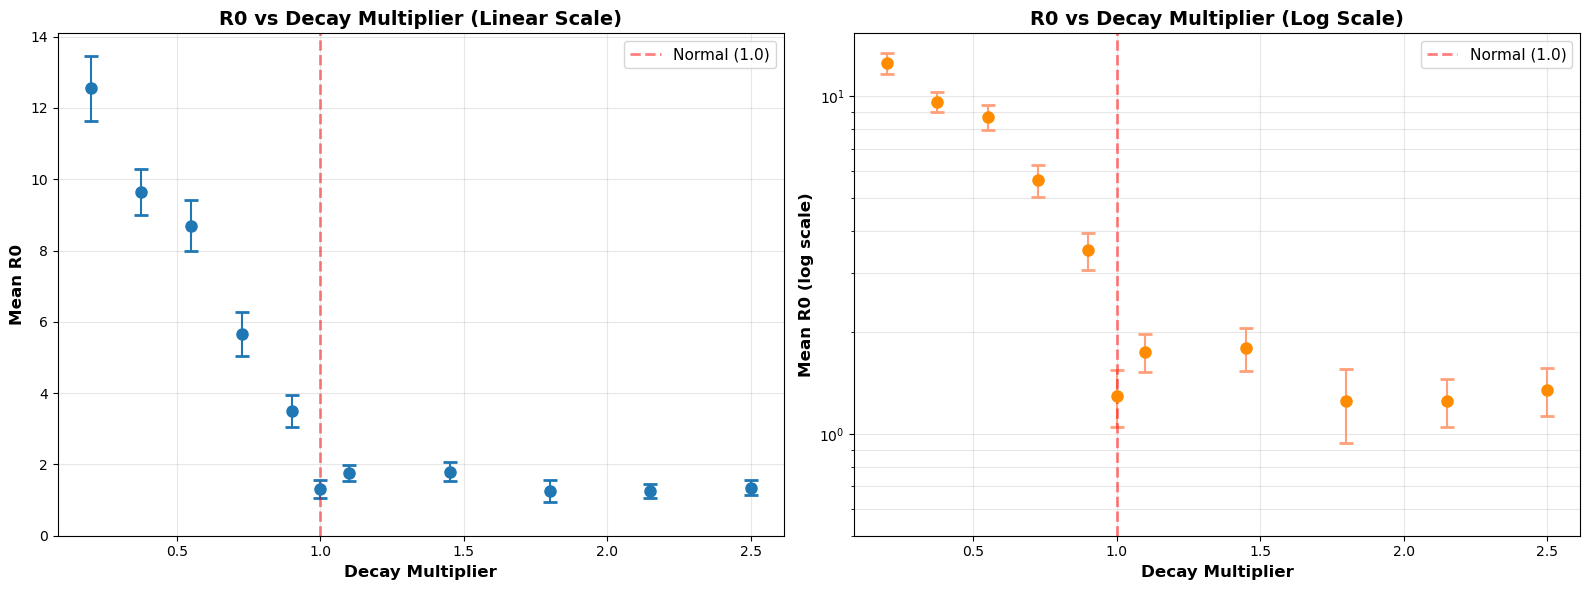


Plot saved to: r0_vs_decay_multiplier.png


In [1034]:
print("="*80)
print("R0 VS DECAY MULTIPLIER - PLOTTING")
print("="*80)

# Create two-panel plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: R0 vs Decay Multiplier (linear scale)
ax1 = axes[0]
ax1.errorbar(df_decay['decay_multiplier'], df_decay['mean_r0'], 
             yerr=df_decay['sem_r0'], fmt='o', markersize=8, capsize=5, capthick=2)
ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Normal (1.0)')
ax1.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean R0', fontsize=12, fontweight='bold')
ax1.set_title('R0 vs Decay Multiplier (Linear Scale)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim(bottom=0)

# Plot 2: Log(R0) vs Decay Multiplier
ax2 = axes[1]
ax2.set_yscale('log')  # Set log scale FIRST
ax2.errorbar(df_decay['decay_multiplier'], df_decay['mean_r0'], 
             yerr=df_decay['sem_r0'], fmt='o', markersize=8,
             color='darkorange', ecolor='lightsalmon', capsize=5, capthick=2)
ax2.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Normal (1.0)')
ax2.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean R0 (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('R0 vs Decay Multiplier (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_ylim(bottom=0.5)
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('r0_vs_decay_multiplier.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nPlot saved to: r0_vs_decay_multiplier.png")

Cell 5c1

In [1017]:
from scipy.optimize import curve_fit

print("="*80)
print("R0 VS MINIMUM PROXIMITY (SOCIAL DISTANCING) SWEEP - DATA COLLECTION")
print("="*80)

n_agents_fixed = N_AGENTS
grid_size_fixed = GRID_SIZE
decay_mult_fixed = DECAY_MULTIPLIER
n_runs_per_proximity = 50
#n_days = 20

# Minimum proximity values: 0m (no distancing) to 5m (strict distancing)
minimum_proximities = np.linspace(0, 5, 20)

print(f"Fixed: {n_agents_fixed} agents, {grid_size_fixed} km grid, decay={decay_mult_fixed}")
print(f"Testing {len(minimum_proximities)} different minimum proximity values")
print(f"Minimum proximity range: {min(minimum_proximities):.1f}m to {max(minimum_proximities):.1f}m")
print(f"Runs per proximity: {n_runs_per_proximity}")
print(f"Total simulations: {len(minimum_proximities) * n_runs_per_proximity}")
print(f"Max transmission distance: {MAX_TRANSMISSION_DISTANCE}"

results_proximity = []

start_total = time.time()
for i, min_prox in enumerate(minimum_proximities):
    print(f"\n[{i+1}/{len(minimum_proximities)}] Testing minimum proximity = {min_prox:.1f}m...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_proximity):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size_fixed,
                        decay_multiplier=decay_mult_fixed, minimum_proximity=min_prox,
                        n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    sem_r0 = stats.sem(r0_values)
    
    results_proximity.append({
        'minimum_proximity': min_prox,
        'mean_r0': mean_r0,
        'sem_r0': sem_r0
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {sem_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_proximity = pd.DataFrame(results_proximity)

print("\n" + "="*80)
print("MINIMUM PROXIMITY SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")

R0 VS MINIMUM PROXIMITY (SOCIAL DISTANCING) SWEEP - DATA COLLECTION
Fixed: 1170 agents, 0.5 km grid, decay=1.0
Testing 20 different minimum proximity values
Minimum proximity range: 0.0m to 5.0m
Runs per proximity: 50
Total simulations: 1000

[1/20] Testing minimum proximity = 0.0m...
  Mean R0 = 2.00 ± 0.21 (time: 29.7s)

[2/20] Testing minimum proximity = 0.3m...
  Mean R0 = 1.90 ± 0.20 (time: 29.2s)

[3/20] Testing minimum proximity = 0.5m...
  Mean R0 = 1.76 ± 0.20 (time: 29.4s)

[4/20] Testing minimum proximity = 0.8m...
  Mean R0 = 1.84 ± 0.17 (time: 30.1s)

[5/20] Testing minimum proximity = 1.1m...
  Mean R0 = 1.66 ± 0.21 (time: 29.9s)

[6/20] Testing minimum proximity = 1.3m...
  Mean R0 = 1.84 ± 0.19 (time: 33.3s)

[7/20] Testing minimum proximity = 1.6m...
  Mean R0 = 1.86 ± 0.22 (time: 30.2s)

[8/20] Testing minimum proximity = 1.8m...
  Mean R0 = 1.62 ± 0.18 (time: 31.1s)

[9/20] Testing minimum proximity = 2.1m...
  Mean R0 = 1.56 ± 0.14 (time: 30.0s)

[10/20] Testing min

cell 5c2

R0 VS MINIMUM PROXIMITY - PLOTTING


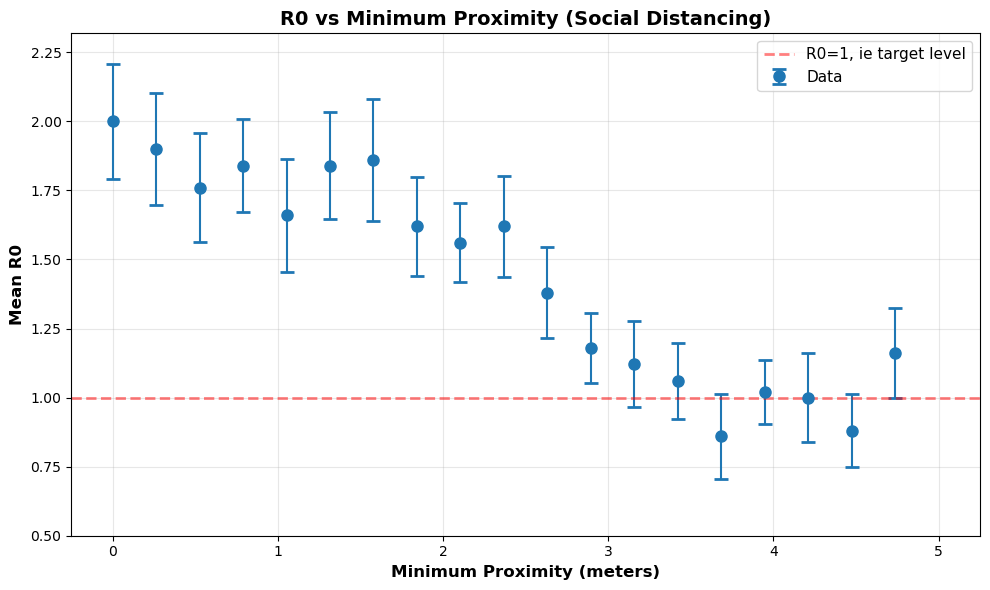


Plot saved to: r0_vs_minimum_proximity.png


In [1023]:
print("="*80)
print("R0 VS MINIMUM PROXIMITY - PLOTTING")
print("="*80)

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(df_proximity['minimum_proximity'], df_proximity['mean_r0'], 
             yerr=df_proximity['sem_r0'], fmt='o', markersize=8, capsize=5, capthick=2, 
             label='Data')

plt.xlabel('Minimum Proximity (meters)', fontsize=12, fontweight='bold')
plt.ylabel('Mean R0', fontsize=12, fontweight='bold')
plt.title('R0 vs Minimum Proximity (Social Distancing)', fontsize=14, fontweight='bold')
#plt.axvline(x=1.5, color='red', linestyle='--', alpha=0.5, linewidth=2, label='2m social distancing guidelines')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=2, label='R0=1, ie target level')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(bottom=0.5)

plt.tight_layout()
plt.savefig('r0_vs_minimum_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_minimum_proximity.png")

Cell 6

In [161]:
def simulate_epidemic(n_days=500, initial_infected=1, initial_recovered_fraction=0.0,
                     circuit_breaker=False,
                     lockdown_threshold=0.25, 
                     unlock_threshold=0.05,
                     lockdown_movement_factor=1.0, 
                     lockdown_transmission_factor=1.0,
                     herd_immunity_test=False,
                     verbose=True):
    
    # Convert fraction to number of agents
    initial_recovered = int(initial_recovered_fraction * N_AGENTS)
    
    agents = initialize_population(N_AGENTS, initial_infected, initial_recovered, 
                                   for_r0_calculation=False)
    
    # Track unique agents that have ever been infected
    ever_infected_ids = set()
    for agent in agents:
        if agent.status == 'infected':
            ever_infected_ids.add(id(agent))
    
    stats = {
        'day': [],
        'susceptible': [],
        'infected': [],
        'recovered': [],
        'cumulative_infections': [],
        'lockdown_active': []
    }
    
    n_steps = int(n_days / DT)
    lockdown_active = False
    
    # Store original D for restoration
    original_D = D
    current_D = D
    
    if verbose and circuit_breaker:
        print(f"Circuit breaker parameters:")
        print(f"  Lockdown triggers at: {lockdown_threshold*100:.0f}% infected")
        print(f"  Lockdown lifts at: {unlock_threshold*100:.0f}% infected")
        print(f"  Lockdown movement: {lockdown_movement_factor*100:.0f}% of normal")
        print(f"  Lockdown transmission: {lockdown_transmission_factor*100:.0f}% of normal")
        print()
    
    for step in range(n_steps + 1):
        # Count current infections
        n_infected = sum(1 for a in agents if a.status == 'infected')
        
        # Check if epidemic has ended
        if step > 0 and n_infected == 0:
            if verbose:
                print(f"\n✓ Epidemic ended at day {step * DT:.1f} (no active infections)")
            break
        
        # Circuit breaker logic (only if enabled)
        if circuit_breaker:
            infection_fraction = n_infected / N_AGENTS
            
            if not lockdown_active and infection_fraction >= lockdown_threshold:
                lockdown_active = True
                current_D = original_D * (lockdown_movement_factor ** 2)
                if verbose:
                    print(f"🔒 LOCKDOWN TRIGGERED at day {step * DT:.1f} ({infection_fraction*100:.1f}% infected)")
            
            elif lockdown_active and infection_fraction <= unlock_threshold:
                lockdown_active = False
                current_D = original_D
                if verbose:
                    print(f"🔓 LOCKDOWN LIFTED at day {step * DT:.1f} ({infection_fraction*100:.1f}% infected)")
        
        # Move all agents (skip on step 0)
        if step > 0:
            for agent in agents:
                agent.move(current_D, DT)
            
            # Attempt transmissions with optional lockdown factor
            if circuit_breaker and lockdown_active and lockdown_transmission_factor != 1.0:
                # Apply transmission reduction during lockdown
                original_transmission_func = transmission_probability_distance
                
                def lockdown_transmission(distance, minimum_proximity=0.0):
                    return original_transmission_func(distance, minimum_proximity) * lockdown_transmission_factor
                
                # Monkey patch the transmission function
                import sys
                current_module = sys.modules[__name__]
                setattr(current_module, 'transmission_probability_distance', lockdown_transmission)
                
                new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
                
                # Restore original function
                setattr(current_module, 'transmission_probability_distance', original_transmission_func)
            else:
                # Normal transmission (no lockdown or lockdown disabled)
                new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
            
            # Update set of ever-infected agents
            for agent in agents:
                if agent.status == 'infected':
                    ever_infected_ids.add(id(agent))
            
            # Update infection status
            for agent in agents:
                agent.update_infection_status(DT)
        
        # Record statistics every ~1 day (adjust based on your DT)
        steps_per_day = int(1.0 / DT)
        if step % steps_per_day == 0:
            current_day = step * DT
            n_susceptible = sum(1 for a in agents if a.status == 'susceptible')
            n_infected = sum(1 for a in agents if a.status == 'infected')
            n_recovered = sum(1 for a in agents if a.status == 'recovered')
            cumulative = len(ever_infected_ids)
            
            stats['day'].append(current_day)
            stats['susceptible'].append(n_susceptible)
            stats['infected'].append(n_infected)
            stats['recovered'].append(n_recovered)
            stats['cumulative_infections'].append(cumulative)
            stats['lockdown_active'].append(lockdown_active)
            
            if verbose and int(current_day) % 10 == 0:
                if circuit_breaker:
                    lockdown_status = "🔒 LOCKDOWN" if lockdown_active else "🔓 Normal"
                    print(f"Day {int(current_day)}: S={n_susceptible}, I={n_infected}, R={n_recovered}, "
                          f"Cumulative={cumulative} | {lockdown_status}")
                else:
                    print(f"Day {int(current_day)}: S={n_susceptible}, I={n_infected}, R={n_recovered}, Cumulative={cumulative}")
    
    if verbose:
        final_cumulative = stats['cumulative_infections'][-1]
        print(f"\nFinal statistics:")
        print(f"Total infected: {final_cumulative} ({100*final_cumulative/N_AGENTS:.1f}%)")
        print(f"Final recovered: {stats['recovered'][-1]}")
        print(f"Remaining susceptible: {stats['susceptible'][-1]}")
        print(f"Epidemic duration: {stats['day'][-1]:.0f} days")
        
        if circuit_breaker:
            lockdown_days = sum(stats['lockdown_active'])
            print(f"Total days in lockdown: {lockdown_days} ({100*lockdown_days/len(stats['day']):.1f}%)")
    
    return stats, agents

print("Use circuit_breaker=False for standard epidemic")
print("Use circuit_breaker=True with threshold parameters for lockdown policy")

Use circuit_breaker=False for standard epidemic
Use circuit_breaker=True with threshold parameters for lockdown policy



TEST 1: Standard Epidemic (no circuit breaker)
Day 0: S=1169, I=1, R=0, Cumulative=1
Day 10: S=1165, I=5, R=0, Cumulative=5
Day 20: S=1150, I=19, R=1, Cumulative=20
Day 30: S=1104, I=56, R=10, Cumulative=66
Day 40: S=975, I=160, R=35, Cumulative=195
Day 50: S=663, I=392, R=115, Cumulative=507
Day 60: S=390, I=462, R=318, Cumulative=780
Day 70: S=287, I=243, R=640, Cumulative=883
Day 80: S=248, I=81, R=841, Cumulative=922
Day 90: S=236, I=25, R=909, Cumulative=934
Day 100: S=233, I=6, R=931, Cumulative=937
Day 110: S=232, I=2, R=936, Cumulative=938

✓ Epidemic ended at day 117.8 (no active infections)

Final statistics:
Total infected: 938 (80.2%)
Final recovered: 937
Remaining susceptible: 232
Epidemic duration: 117 days


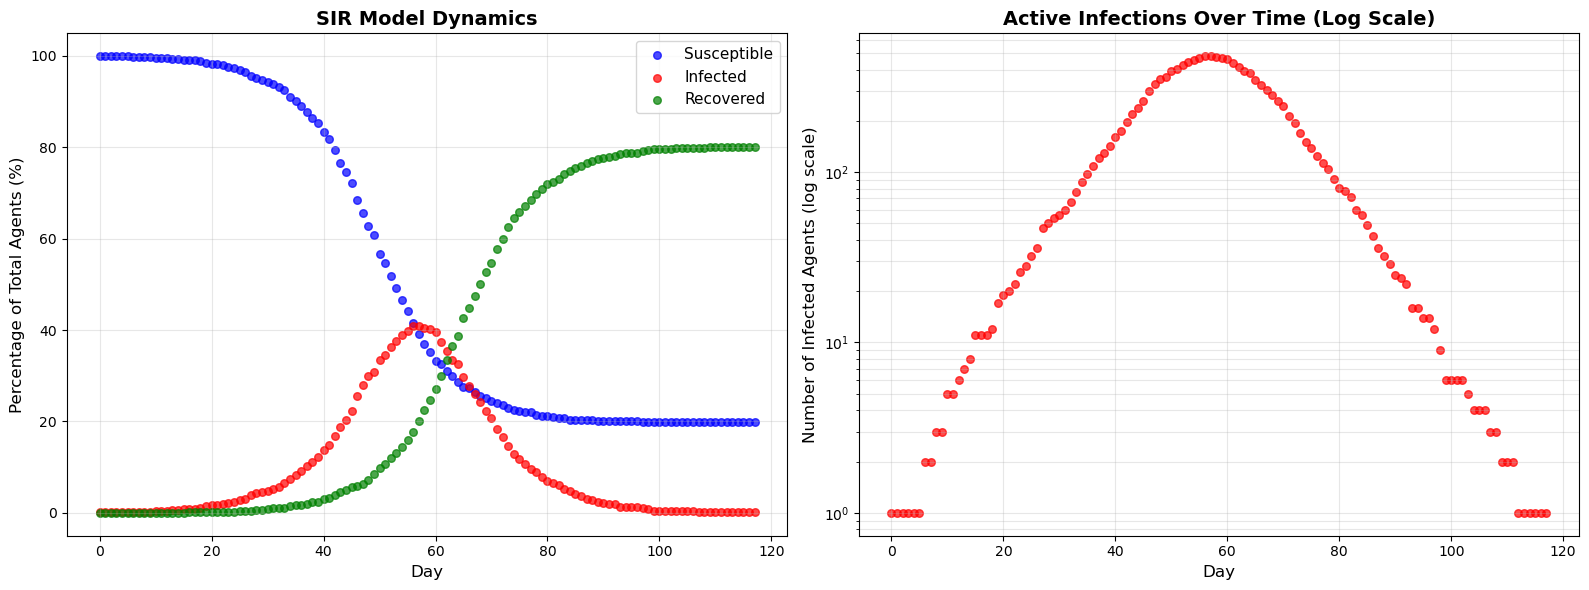


Visualization complete! Saved as 'covid_simulation_results.png'


In [109]:
# Test 1: Standard epidemic
print("\n" + "="*80)
print("TEST 1: Standard Epidemic (no circuit breaker)")
print("="*80)
epidemic_stats, final_agents = simulate_epidemic(
    initial_infected=1,
    circuit_breaker=False,
    verbose=True
)

# Calculate total agents for percentage conversion
total_agents = epidemic_stats['susceptible'][0] + epidemic_stats['infected'][0] + epidemic_stats['recovered'][0]

# Create two-panel plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All compartments (SIR) as percentages
ax1 = axes[0]
ax1.scatter(epidemic_stats['day'], [s/total_agents * 100 for s in epidemic_stats['susceptible']], c='blue', s=30, alpha=0.7, label='Susceptible')
ax1.scatter(epidemic_stats['day'], [i/total_agents * 100 for i in epidemic_stats['infected']], c='red', s=30, alpha=0.7, label='Infected')
ax1.scatter(epidemic_stats['day'], [r/total_agents * 100 for r in epidemic_stats['recovered']], c='green', s=30, alpha=0.7, label='Recovered')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Percentage of Total Agents (%)', fontsize=12)
ax1.set_title('SIR Model Dynamics', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: Log scale for infected (to see exponential growth)
ax2 = axes[1]
infected_nonzero = [max(i, 0.1) for i in epidemic_stats['infected']]  # Avoid log(0)
ax2.scatter(epidemic_stats['day'], infected_nonzero, c='red', s=30, alpha=0.7)
ax2.set_yscale('log')
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Number of Infected Agents (log scale)', fontsize=12)
ax2.set_title('Active Infections Over Time (Log Scale)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('covid_simulation_results.png', dpi=300, bbox_inches='tight')
plt.show()

Cell 7

for crcuit breaker - reduce D to 0, if doesnt stop outbreak, then only allow transmissions
once per day...

Cell 8

In [103]:
# Circuit breaker comparison across three trigger thresholds WITH REDUCTON IN T(d):
print("\n" + "="*80)
print("CIRCUIT BREAKER COMPARISON: 10%, 20%, 30% lockdown triggers")
print("="*80)

# Define thresholds and colours
thresholds = [0.1, 0.2, 0.3]
colours = ['blue', 'green', 'red']
labels = ['Trigger at 10%', 'Trigger at 20%', 'Trigger at 30%']

# Store results for each threshold
all_stats = []

for thresh in thresholds:
    print(f"\n--- Running with {thresh*100:.0f}% lockdown threshold ---")
    stats, _ = simulate_epidemic(
        initial_infected=5,
        circuit_breaker=True,
        lockdown_threshold=thresh,
        unlock_threshold=0.05,
        lockdown_movement_factor=0.1,
        lockdown_transmission_factor=0.3,
        verbose=True
    )
    all_stats.append(stats)



CIRCUIT BREAKER COMPARISON: 10%, 20%, 30% lockdown triggers

--- Running with 10% lockdown threshold ---
Circuit breaker parameters:
  Lockdown triggers at: 10% infected
  Lockdown lifts at: 5% infected
  Lockdown movement: 10% of normal
  Lockdown transmission: 30% of normal

Day 0: S=1165, I=5, R=0, Cumulative=5 | 🔓 Normal
Day 10: S=1146, I=24, R=0, Cumulative=24 | 🔓 Normal
Day 20: S=1058, I=102, R=10, Cumulative=112 | 🔓 Normal
🔒 LOCKDOWN TRIGGERED at day 21.0 (10.0% infected)
Day 30: S=998, I=127, R=45, Cumulative=172 | 🔒 LOCKDOWN
🔓 LOCKDOWN LIFTED at day 39.1 (4.9% infected)
Day 40: S=970, I=58, R=142, Cumulative=200 | 🔓 Normal
Day 50: S=918, I=66, R=186, Cumulative=252 | 🔓 Normal
🔒 LOCKDOWN TRIGGERED at day 55.6 (10.0% infected)
Day 60: S=835, I=121, R=214, Cumulative=335 | 🔒 LOCKDOWN
🔓 LOCKDOWN LIFTED at day 69.6 (5.0% infected)
Day 70: S=815, I=54, R=301, Cumulative=355 | 🔓 Normal
Day 80: S=787, I=37, R=346, Cumulative=383 | 🔓 Normal
Day 90: S=746, I=61, R=363, Cumulative=424 |

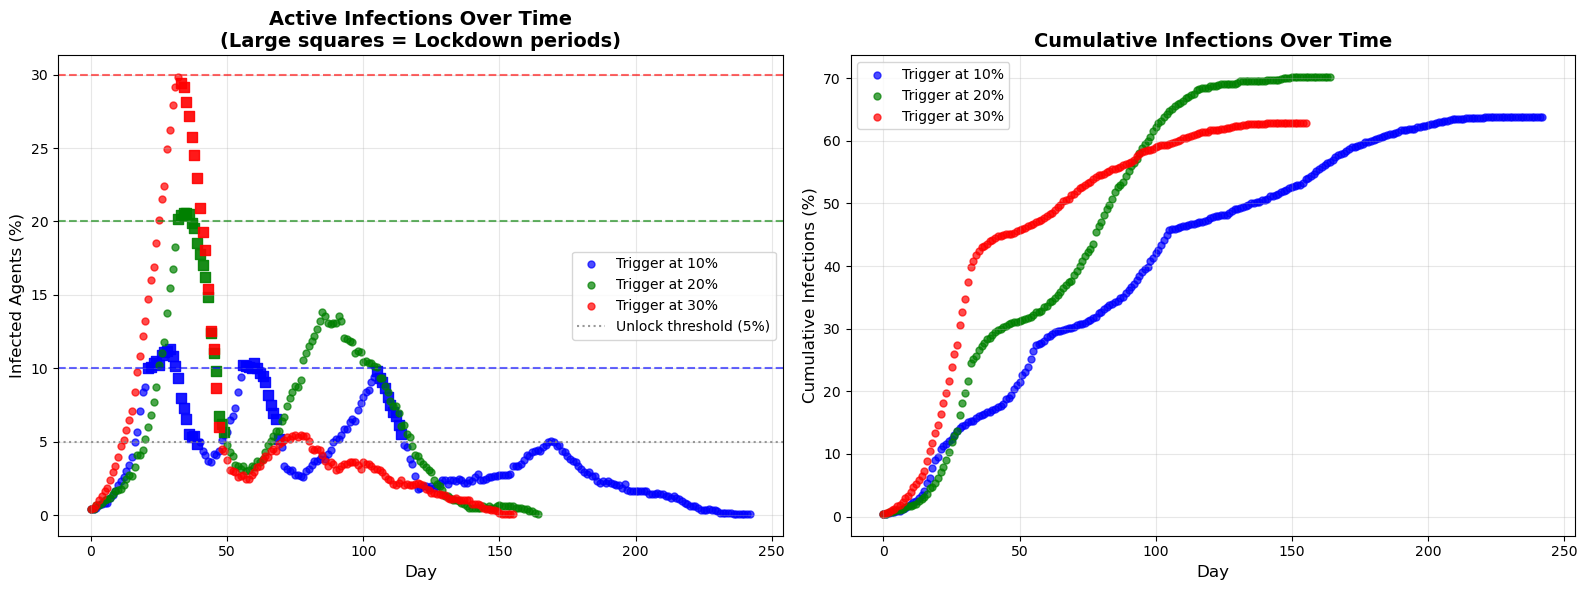

In [105]:
# Create two-panel comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Active infections over time (as percentage) - with lockdown markers
ax1 = axes[0]
for i, (stats, colour, label, thresh) in enumerate(zip(all_stats, colours, labels, thresholds)):
    days = stats['day']
    infected_pct = [100 * inf / N_AGENTS for inf in stats['infected']]
    lockdown = stats['lockdown_active']
    
    # Separate lockdown and non-lockdown points
    days_normal = [d for d, lock in zip(days, lockdown) if not lock]
    infected_normal = [inf for inf, lock in zip(infected_pct, lockdown) if not lock]
    days_lockdown = [d for d, lock in zip(days, lockdown) if lock]
    infected_lockdown = [inf for inf, lock in zip(infected_pct, lockdown) if lock]
    
    # Plot normal periods (circles)
    ax1.scatter(days_normal, infected_normal, c=colour, s=25, alpha=0.7, marker='o', label=label)
    # Plot lockdown periods (squares)
    ax1.scatter(days_lockdown, infected_lockdown, c=colour, s=50, alpha=0.9, marker='s')
    
    # Plot trigger threshold line
    ax1.axhline(y=thresh * 100, color=colour, linestyle='--', alpha=0.6, linewidth=1.5)

# Plot unlock threshold line (common to all)
ax1.axhline(y=5, color='grey', linestyle=':', alpha=0.8, linewidth=1.5, label='Unlock threshold (5%)')

ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Infected Agents (%)', fontsize=12)
ax1.set_title('Active Infections Over Time\n(Large squares = Lockdown periods)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Cumulative infections over time (as percentage) - uniform markers
ax2 = axes[1]
for i, (stats, colour, label) in enumerate(zip(all_stats, colours, labels)):
    days = stats['day']
    cumulative_pct = [100 * c / N_AGENTS for c in stats['cumulative_infections']]
    
    # Plot all points uniformly
    ax2.scatter(days, cumulative_pct, c=colour, s=25, alpha=0.7, label=label)

ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Cumulative Infections (%)', fontsize=12)
ax2.set_title('Cumulative Infections Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig('circuit_breaker_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Cell 9


HERD IMMUNITY ANALYSIS

--- Running with 0% initial immunity ---
Day 0: S=1165, I=5, R=0, Cumulative=5
Day 10: S=1137, I=33, R=0, Cumulative=33
Day 20: S=1036, I=125, R=9, Cumulative=134
Day 30: S=825, I=281, R=64, Cumulative=345
Day 40: S=566, I=383, R=221, Cumulative=604
Day 50: S=364, I=338, R=468, Cumulative=806
Day 60: S=255, I=210, R=705, Cumulative=915
Day 70: S=222, I=77, R=871, Cumulative=948
Day 80: S=215, I=15, R=940, Cumulative=955
Day 90: S=211, I=7, R=952, Cumulative=959
Day 100: S=211, I=2, R=957, Cumulative=959

✓ Epidemic ended at day 100.8 (no active infections)

Final statistics:
Total infected: 959 (82.0%)
Final recovered: 957
Remaining susceptible: 211
Epidemic duration: 100 days

--- Running with 20% initial immunity ---
Day 0: S=931, I=5, R=234, Cumulative=5
Day 10: S=898, I=38, R=234, Cumulative=38
Day 20: S=805, I=114, R=251, Cumulative=131
Day 30: S=660, I=206, R=304, Cumulative=276
Day 40: S=502, I=238, R=430, Cumulative=434
Day 50: S=393, I=184, R=593, Cumu

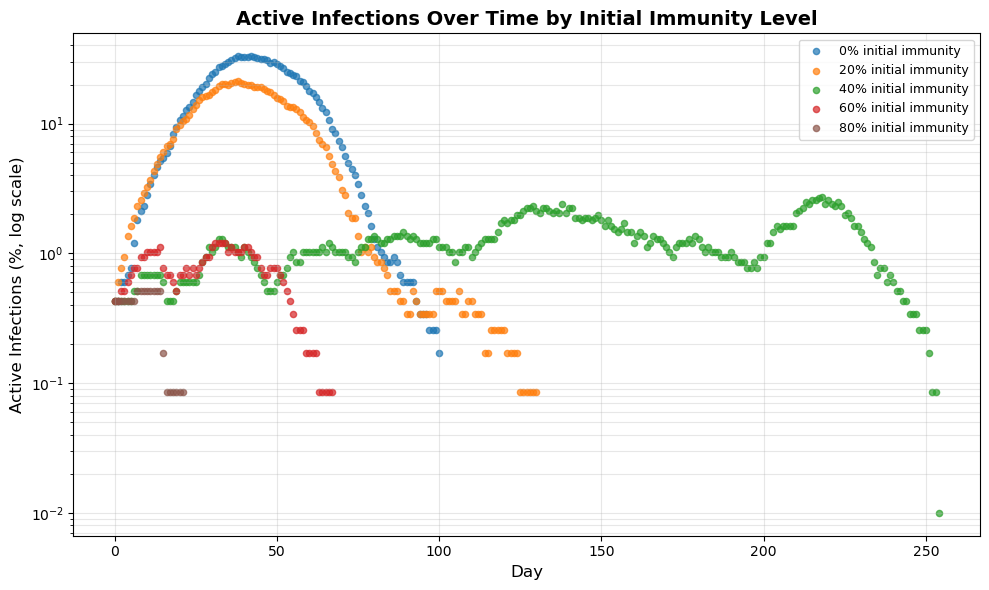

In [121]:
# Herd immunity analysis
print("\n" + "="*80)
print("HERD IMMUNITY ANALYSIS")
print("="*80)

# Test different initial immunity fractions
immunity_fractions = np.linspace(0, 0.8, 5)
colours = plt.cm.tab10(np.linspace(0, 0.5, 5)) 

# Store results
all_stats = []

for frac in immunity_fractions:
    print(f"\n--- Running with {frac*100:.0f}% initial immunity ---")
    stats, _ = simulate_epidemic(
        initial_infected=5,
        initial_recovered_fraction=frac,
        circuit_breaker=False,
        herd_immunity_test=True,
        verbose=True
    )
    all_stats.append(stats)

# Plot active infections over time for each immunity level (log scale)
fig, ax = plt.subplots(figsize=(10, 6))

for i, (stats, frac) in enumerate(zip(all_stats, immunity_fractions)):
    days = stats['day']
    infected_pct = [100 * inf / N_AGENTS for inf in stats['infected']]
    # Avoid log(0) by setting a small floor
    infected_pct_log = [max(val, 0.01) for val in infected_pct]
    
    ax.scatter(days, infected_pct_log, c=[colours[i]], s=20, alpha=0.7, 
               label=f'{frac*100:.0f}% initial immunity')

ax.set_yscale('log')
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Active Infections (%, log scale)', fontsize=12)
ax.set_title('Active Infections Over Time by Initial Immunity Level', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.savefig('herd_immunity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


HERD IMMUNITY ANALYSIS

--- Running with 35% initial immunity ---
Day 0: S=756, I=5, R=409, Cumulative=5
Day 10: S=753, I=8, R=409, Cumulative=8
Day 20: S=746, I=10, R=414, Cumulative=15
Day 30: S=733, I=18, R=419, Cumulative=28
Day 40: S=716, I=28, R=426, Cumulative=45
Day 50: S=690, I=35, R=445, Cumulative=71
Day 60: S=657, I=49, R=464, Cumulative=104
Day 70: S=622, I=56, R=492, Cumulative=139
Day 80: S=579, I=64, R=527, Cumulative=182
Day 90: S=529, I=78, R=563, Cumulative=232
Day 100: S=479, I=73, R=618, Cumulative=282
Day 110: S=456, I=49, R=665, Cumulative=305
Day 120: S=431, I=37, R=702, Cumulative=330
Day 130: S=416, I=28, R=726, Cumulative=345
Day 140: S=409, I=11, R=750, Cumulative=352
Day 150: S=401, I=9, R=760, Cumulative=360
Day 160: S=399, I=5, R=766, Cumulative=362
Day 170: S=399, I=1, R=770, Cumulative=362

✓ Epidemic ended at day 174.0 (no active infections)

Final statistics:
Total infected: 362 (30.9%)
Final recovered: 770
Remaining susceptible: 399
Epidemic duratio

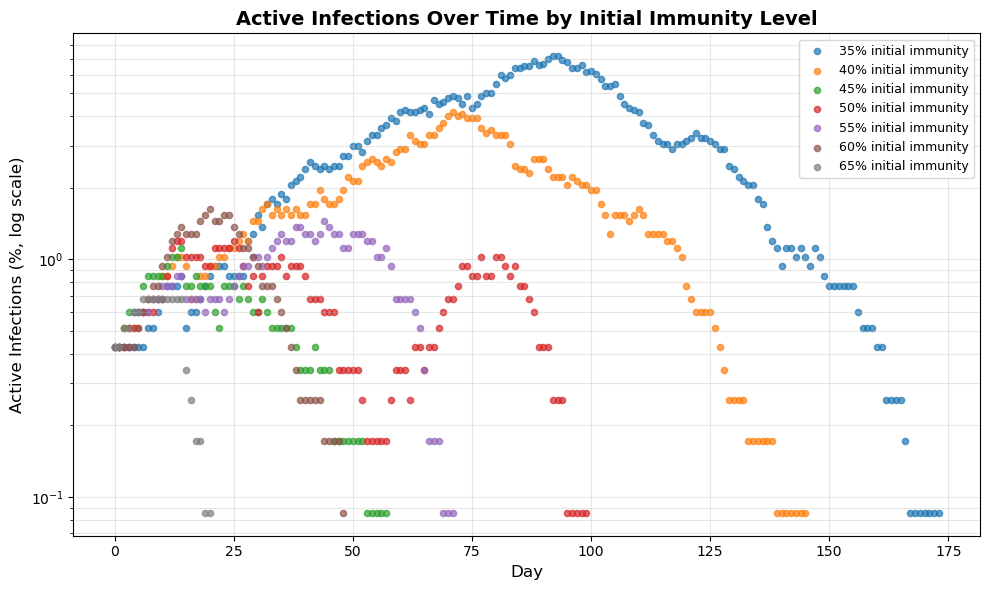

In [137]:
# Herd immunity analysis - zooming in on 40% initial immunity
print("\n" + "="*80)
print("HERD IMMUNITY ANALYSIS")
print("="*80)

# Test different initial immunity fractions
immunity_fractions = np.linspace(0.35, 0.65, 7)
colours = plt.cm.tab10(np.linspace(0, 0.7, 7)) 

# Store results
all_stats = []

for frac in immunity_fractions:
    print(f"\n--- Running with {frac*100:.0f}% initial immunity ---")
    stats, _ = simulate_epidemic(
        initial_infected=5,
        initial_recovered_fraction=frac,
        circuit_breaker=False,
        herd_immunity_test=True,
        verbose=True
    )
    all_stats.append(stats)

# Plot active infections over time for each immunity level (log scale)
fig, ax = plt.subplots(figsize=(10, 6))

for i, (stats, frac) in enumerate(zip(all_stats, immunity_fractions)):
    days = stats['day']
    infected_pct = [100 * inf / N_AGENTS for inf in stats['infected']]
    # Avoid log(0) by setting a small floor
    infected_pct_log = [max(val, 0.01) for val in infected_pct]
    
    ax.scatter(days, infected_pct_log, c=[colours[i]], s=20, alpha=0.7, 
               label=f'{frac*100:.0f}% initial immunity')

ax.set_yscale('log')
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Active Infections (%, log scale)', fontsize=12)
ax.set_title('Active Infections Over Time by Initial Immunity Level', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.savefig('herd_immunity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()